Import Libraries 

In [ ]:
!pip install tensorflow

In [2]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [3]:
#Used for Optimized Neural Net (KerasClassifier)
!pip install scikeras

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score,
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout #Not used under current models but may be needed for Neural Net
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

Data Preprocessing 

In [2]:

# All CSV files in a directory (files are contracts of all NAICS codes PeopleTec has won a contract for)
files = glob.glob('C:/PeopleTec Data Sources/Build Model/*.csv')

# Read and concatenate the files
combined_df = pd.concat([pd.read_csv(file, encoding='latin1') for file in files])
len(combined_df)

#Creating column for independent variable
combined_df['Is_PeopleTec'] = (combined_df['Legal Business Name'] == 'PEOPLETEC, INC.').astype(bool)

count_ones = (combined_df['Is_PeopleTec'] == 1).sum()

print("Number of entries where 'Is_PeopleTec' is equal to 1:", count_ones)

import re

# Remove non-numeric characters
combined_df['Action Obligation ($)'] = combined_df['Action Obligation ($)'].apply(lambda x: re.sub(r'[^0-9.]', '', x))

#Encode STR datatypes
label_encoder = LabelEncoder()
combined_df['PSC_encoded'] = label_encoder.fit_transform(combined_df['PSC'])
combined_df['PSCType_encoded'] = label_encoder.fit_transform(combined_df['PSC Type'])
combined_df['AgencyID_encoded'] = label_encoder.fit_transform(combined_df['Contracting Agency ID'])

# Convert DataTypes for Variables
combined_df['Action Obligation ($)'] = combined_df['Action Obligation ($)'].astype(float)
combined_df['Date Signed'] = pd.to_datetime(combined_df['Date Signed'], format='%b %d, %Y')

# Extract year, month, and day from 'Date Signed'
combined_df['Year_Signed'] = combined_df['Date Signed'].dt.year
combined_df['Month_Signed'] = combined_df['Date Signed'].dt.month
combined_df['Day_Signed'] = combined_df['Date Signed'].dt.day

# Drop the original 'Date Signed' column
combined_df.drop('Date Signed', axis=1, inplace=True)

# Filter the DataFrame where 'Is_PeopleTec' is True
peopletec_true_df = combined_df[combined_df['Is_PeopleTec'] == True]

# Find the earliest year PeopleTec was competing for contracts
earliest_year = peopletec_true_df['Year_Signed'].min()

print("Earliest instance of 'Is_PeopleTec' being 1 is in the year:", earliest_year)
#Remove contracts in previous years as they will hurt the model performance
combined_df = combined_df[combined_df['Year_Signed'] >= earliest_year]

print(combined_df.shape)

Number of entries where 'Is_PeopleTec' is equal to 1: 235
Earliest instance of 'Is_PeopleTec' being 1 is in the year: 2010
(152173, 33)


<Axes: xlabel='Year_Signed', ylabel='Is_PeopleTec'>

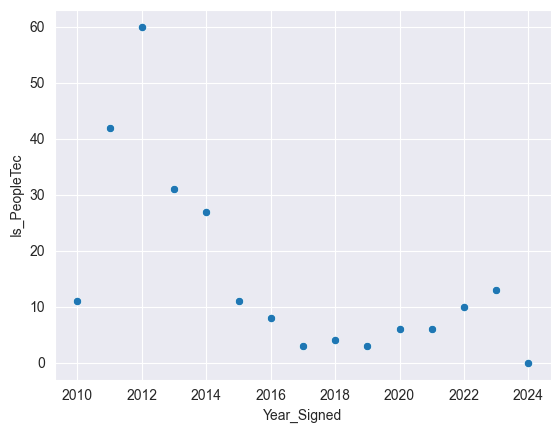

In [3]:
# Aggregate the data to get the sum of 'Is_PeopleTec' for each 'Year_Signed'
yearly_data = combined_df.groupby('Year_Signed')['Is_PeopleTec'].sum().reset_index()

# Now plot using seaborn
sns.scatterplot(data=yearly_data, x="Year_Signed", y="Is_PeopleTec")

In [4]:
print(combined_df.dtypes)

Contract ID                             object
Reference IDV                           object
Modification Number                     object
Transaction Number                       int64
Award/IDV Type                          object
Action Obligation ($)                  float64
Solicitation Date                       object
Contracting Agency ID                   object
Contracting Agency                      object
Contracting Office Name                 object
PSC Type                                object
PSC                                     object
PSC Description                         object
NAICS                                    int64
NAICS Description                       object
Entity City                             object
Entity State                            object
Entity ZIP Code                         object
Additional Reporting Code               object
Additional Reporting Description        object
Unique Entity ID                        object
Ultimate Pare

Splitting Data

In [5]:
#Spliting data with 80/20 split
x = combined_df[['Action Obligation ($)','PSC_encoded', 'PSCType_encoded', 'AgencyID_encoded']]
y = combined_df['Is_PeopleTec'] #independent variable is if PeopleTec won the contract
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20,random_state=0)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform scaler on training features
x_train_scaled = scaler.fit_transform(x_train)

# Transform testing features using the fitted scaler
x_test_scaled = scaler.transform(x_test)

<Axes: >

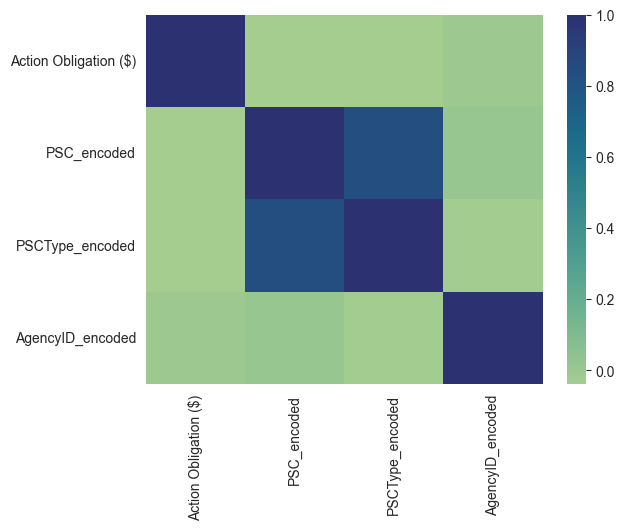

In [9]:
sns.heatmap(x.corr(), cmap="crest")

In [6]:
#Fixing Imbalance in dataset using SMOTE 
from imblearn.over_sampling import SMOTE

# Data resampling with SMOTE
smote = SMOTE(sampling_strategy='auto')
smote_X_train, smote_Y_train = smote.fit_resample(x_train, y_train)

Classifaction Tree

In [11]:
# Build Classification Tree
tree = DecisionTreeClassifier(random_state=0)
tree.fit(smote_X_train, smote_Y_train)  # Use smote_Y_train here

# Predictions
pred_test = tree.predict(x_test)  # Use original x_test here
tree_acc = accuracy_score(pred_test, y_test)
print("Test accuracy:", tree_acc)

pred_train = tree.predict(smote_X_train)
print("Train accuracy:", accuracy_score(pred_train, smote_Y_train))  # Use smote_Y_train for accuracy

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, pred_test)
print("Confusion Matrix:")
print(conf_matrix)

Test accuracy: 0.9732216198455725
Train accuracy: 0.9877550180980585
Confusion Matrix:
[[29597   781]
 [   34    23]]


<Axes: >

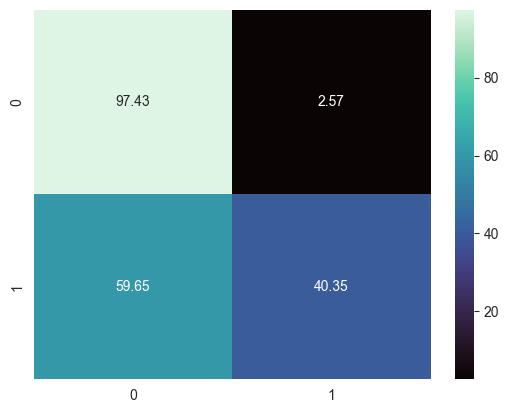

In [12]:
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_conf_matrix * 100, cmap='mako', annot=True, fmt=".2f")

Random Forest Classifier 

In [13]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

#Build Model
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)} #parameters

clf = RandomForestClassifier()
# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(clf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

rand_search.fit(smote_X_train, smote_Y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

pred_test = best_rf.predict(x_test)  # Use original x_test here
forest_acc = accuracy_score(y_test, pred_test)
print("Test accuracy:", forest_acc)

pred_train = best_rf.predict(smote_X_train)
print("Train accuracy:", accuracy_score(pred_train, smote_Y_train))  # Use smote_Y_train for accuracy

#Recall
recall = recall_score(y_test, pred_test)
print("Recall:", recall)

# Confusion Matrix
forest_cm = confusion_matrix(y_test, pred_test)
print("Confusion Matrix:")
print(forest_cm)

# False Negative Rate (FNR)
fnr = forest_cm[1, 0] / (forest_cm[1, 0] + forest_cm[1, 1])
print("False Negative Rate (FNR):", fnr)

# False Positive Rate (FPR)
fpr = forest_cm[0, 1] / (forest_cm[0, 0] + forest_cm[0, 1])
print("False Positive Rate (FPR):", fpr)

# Misclassification Rate (MR)
mr = (forest_cm[0, 1] + forest_cm[1, 0]) / (forest_cm[0, 0] + forest_cm[0, 1] + forest_cm[1, 0] + forest_cm[1, 1])
print("Misclassification Rate (MR):", mr)

# Area Under the Curve (AUC)
auc = roc_auc_score(y_test, pred_train)
print("Forest Area Under the Curve (AUC):", auc)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 417}
Test accuracy: 0.9722687695087893
Train accuracy: 0.9856614017769003
Recall: 0.5263157894736842
Confusion Matrix:
[[29561   817]
 [   27    30]]
False Negative Rate (FNR): 0.47368421052631576
False Positive Rate (FPR): 0.026894463098294817
Misclassification Rate (MR): 0.027731230491210776


NameError: name 'roc_auc_score' is not defined

<Axes: >

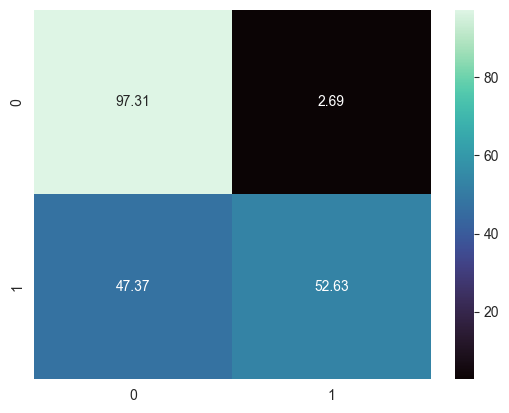

In [14]:
normalized_conf_matrix = forest_cm.astype('float') / forest_cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_conf_matrix * 100, cmap='mako', annot=True, fmt=".2f")

XGBoost Model

In [23]:
# Build XGBoost Model
params = {
    "objective": "binary:logistic",
    "max_depth": 3,
    "learning_rate": 0.1,
    "eval_metric": ["logloss", "error"]
}

dtrain = xgb.DMatrix(smote_X_train, label=smote_Y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtest, "test")],
    early_stopping_rounds=50
)

# Use the best model for further predictions
dpredict = xgb.DMatrix(x_test)  # Convert x_test to DMatrix for prediction
preds = bst.predict(dpredict)

pred_labels = [round(pred) for pred in preds]

# Evaluate accuracy
XG_accuracy = accuracy_score(y_test, pred_labels)
print("XGBoost SMOTE Test accuracy:", XG_accuracy)

recall = recall_score(y_test, pred_labels)
print("Recall:", recall)

# Confusion Matrix
XG_conf_matrix = confusion_matrix(y_test, pred_labels)
print("XGBoost SMOTE Confusion Matrix:")
print(XG_conf_matrix)

# False Negative Rate (FNR)
fnr = XG_conf_matrix[1, 0] / (XG_conf_matrix[1, 0] + XG_conf_matrix[1, 1])
print("False Negative Rate (FNR):", fnr)

# False Positive Rate (FPR)
fpr = XG_conf_matrix[0, 1] / (XG_conf_matrix[0, 0] + XG_conf_matrix[0, 1])
print("False Positive Rate (FPR):", fpr)

# Misclassification Rate (MR)
mr = (XG_conf_matrix[0, 1] + XG_conf_matrix[1, 0]) / (XG_conf_matrix[0, 0] + XG_conf_matrix[0, 1] + XG_conf_matrix[1, 0] + XG_conf_matrix[1, 1])
print("Misclassification Rate (MR):", mr)

# Area Under the Curve (AUC)
auc_score = roc_auc_score(y_test, preds)
print("SMOTE Area Under the Curve (AUC):", auc_score)

[0]	test-logloss:0.63363	test-error:0.01939
[1]	test-logloss:0.58409	test-error:0.01939
[2]	test-logloss:0.54200	test-error:0.01939
[3]	test-logloss:0.50621	test-error:0.01939
[4]	test-logloss:0.47549	test-error:0.02001
[5]	test-logloss:0.44959	test-error:0.02001
[6]	test-logloss:0.42689	test-error:0.02001
[7]	test-logloss:0.40595	test-error:0.02326
[8]	test-logloss:0.38819	test-error:0.02326
[9]	test-logloss:0.37223	test-error:0.02326
[10]	test-logloss:0.35822	test-error:0.02326
[11]	test-logloss:0.34159	test-error:0.02586
[12]	test-logloss:0.33035	test-error:0.02911
[13]	test-logloss:0.32058	test-error:0.02911
[14]	test-logloss:0.31209	test-error:0.02911
[15]	test-logloss:0.30183	test-error:0.03818
[16]	test-logloss:0.29130	test-error:0.03309
[17]	test-logloss:0.28508	test-error:0.03309
[18]	test-logloss:0.27950	test-error:0.03542
[19]	test-logloss:0.27208	test-error:0.03618
[20]	test-logloss:0.26461	test-error:0.03618
[21]	test-logloss:0.25815	test-error:0.04715
[22]	test-logloss:0.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

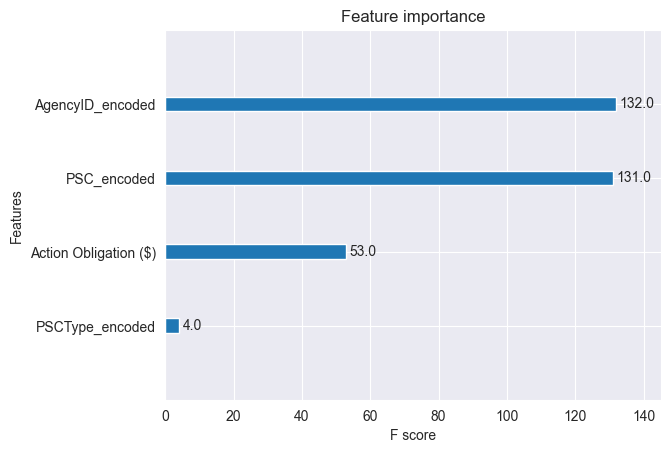

In [24]:
xgb.plot_importance(bst)

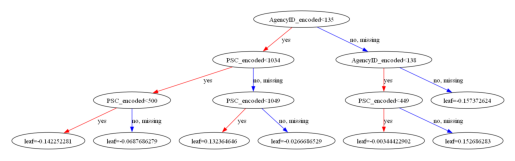

In [25]:
gradient_tree = xgb.plot_tree(bst, num_trees=3)

<Axes: >

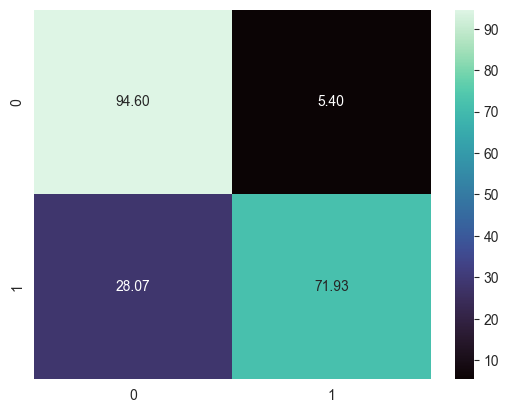

In [27]:
normalized_conf_matrix = XG_conf_matrix.astype('float') / XG_conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_conf_matrix * 100, cmap='mako', annot=True, fmt=".2f")

Optimized Gradient Boosting using GridSearchCV

In [28]:
# Prepare DMatrix
dtrain = xgb.DMatrix(smote_X_train, label=smote_Y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],  # Range of values for max_depth
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]  # Range of values for learning_rate
}

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric=["logloss", "error"], use_label_encoder=False)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='recall', cv=3, verbose=1)

# Fit GridSearchCV
grid_search.fit(smote_X_train, smote_Y_train)

# Best model after grid search
best_model = grid_search.best_estimator_

# Evaluate on test data
accuracy = best_model.score(x_test, y_test)
print("Best model accuracy on test data: {:.2f}%".format(accuracy * 100))
print("Best parameters found: ", grid_search.best_params_)

# You can also use the best model for further predictions
preds = best_model.predict(x_test)

pred_labels = [round(pred) for pred in preds]

# Evaluate accuracy
Opt_XG_accuracy = accuracy_score(y_test, pred_labels)
print("XGBoost SMOTE Test accuracy:", Opt_XG_accuracy)

# Confusion Matrix
Opt_XG_conf_matrix = confusion_matrix(y_test, pred_labels)
print("XGBoost SMOTE Confusion Matrix:")
print(Opt_XG_conf_matrix)

# False Negative Rate (FNR)
fnr = Opt_XG_conf_matrix[1, 0] / (Opt_XG_conf_matrix[1, 0] + Opt_XG_conf_matrix[1, 1])
print("False Negative Rate (FNR):", fnr)

# False Positive Rate (FPR)
fpr = Opt_XG_conf_matrix[0, 1] / (Opt_XG_conf_matrix[0, 0] + Opt_XG_conf_matrix[0, 1])
print("False Positive Rate (FPR):", fpr)

# Misclassification Rate (MR)
mr = (Opt_XG_conf_matrix[0, 1] + Opt_XG_conf_matrix[1, 0]) / (Opt_XG_conf_matrix[0, 0] + Opt_XG_conf_matrix[0, 1] + Opt_XG_conf_matrix[1, 0] + Opt_XG_conf_matrix[1, 1])
print("Misclassification Rate (MR):", mr)

# Area Under the Curve (AUC)
auc = roc_auc_score(y_test, preds)
print("SMOTE Area Under the Curve (AUC):", auc)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best model accuracy on test data: 97.01%
Best parameters found:  {'learning_rate': 0.3, 'max_depth': 7}
XGBoost SMOTE Test accuracy: 0.9700673566617382
XGBoost SMOTE Confusion Matrix:
[[29495   883]
 [   28    29]]
False Negative Rate (FNR): 0.49122807017543857
False Positive Rate (FPR): 0.02906708802422806
Misclassification Rate (MR): 0.02993264333826187
SMOTE Area Under the Curve (AUC): 0.7398524209001667


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

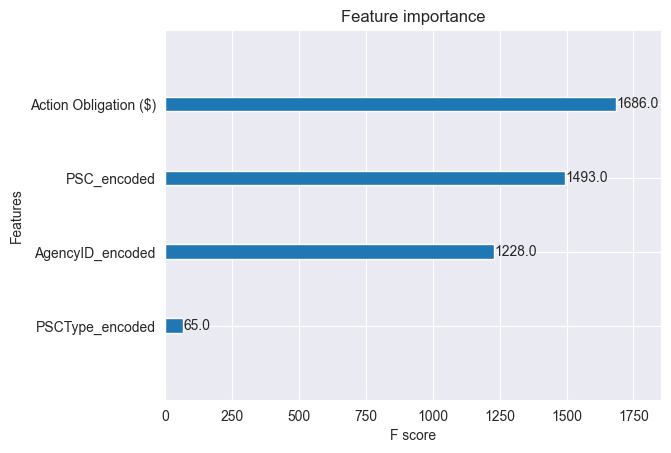

In [29]:
xgb.plot_importance(best_model)

<Axes: >

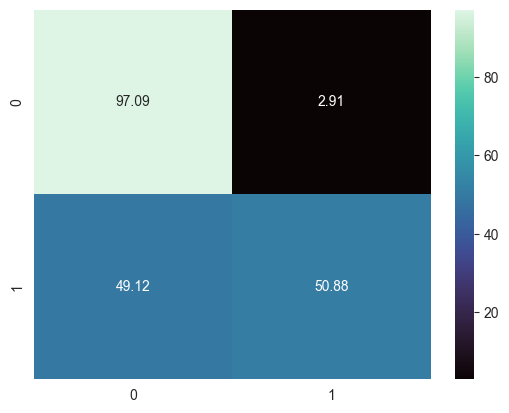

In [30]:
Opt_normalized_cm = Opt_XG_conf_matrix.astype('float') / Opt_XG_conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(Opt_normalized_cm * 100, cmap='mako', annot=True, fmt=".2f")

Support Vector Machine: SVM

In [ ]:
#Takes too much computation than my hardware can handle
from sklearn.svm import SVC
parameter = [{'kernel': ['linear']},
            {'kernel' : ['poly'], 'degree': [2, 3, 4]},
            {'kernel' : ['rbf']}]

grid_search = GridSearchCV(estimator=SVC(), param_grid=parameter, scoring='accuracy') 
grid_search = grid_search.fit(smote_X_train, smote_Y_train)

best_kernel = grid_search.best_params_['kernel']
print("Best Kernel:", best_kernel)

classifier = SVC(kernel=best_kernel)
classifier.fit(smote_X_train, smote_Y_train)
y_pred = classifier.predict(x_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Metrics
accuracy_svm_kernel = accuracy_score(y_pred, y_test)
print("Test accuracy for SVM:",accuracy_svm_kernel)

TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

FNR = FN / (FN + TP)
FPR = FP / (FP + TN)
MR = (FP + FN) / (TP + TN + FP + FN)

print("False Negative Rate (FNR):", FNR)
print("False Positive Rate (FPR):", FPR)
print("Misclassification Rate (MR):", MR)

Neural Network

In [ ]:
#Not working// AttributeError: 'dict' object has no attribute 'set_params' (cannot fix)

from sklearn.datasets import make_classification

# Define the model configuration (using gridsearch to optimize Neural Net). Non-optimized models provide poor results. 
model_config = {
    'build_fn': Sequential,
    'config': {
        'layers': [
            {'class_name': 'Dense', 'config': {'units': 32, 'activation': 'relu', 'input_shape': [10]}},
            {'class_name': 'Dense', 'config': {'units': 1, 'activation': 'sigmoid'}}
        ],
        'compile': {
            'loss': 'binary_crossentropy',
            'optimizer': 'adam',
            'metrics': ['recall']
        }
    }
}

# Define the parameter grid including the units to be tuned
param_grid = {
    'config__layers__1__config__units': [16, 32, 64, 128]  # Specify the units parameter for the second dense layer
}

# Initialize GridSearchCV with the model configuration
grid = GridSearchCV(estimator=KerasClassifier(**model_config), param_grid=param_grid, n_jobs=-1, cv=3, scoring='recall')

# Fit GridSearchCV
grid_result = grid.fit(smote_X_train, smote_Y_train)

# Print best parameters and best score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Evaluate using the best estimator
best_model = grid_result.best_estimator_
y_hat = best_model.predict(x_test)
y_hat = np.round(y_hat).astype(int)
NN_acc = accuracy_score(y_test, y_hat)
print("Neural Network Test accuracy with best model:", NN_acc)

# Confusion Matrix
cm = confusion_matrix(y_test, y_hat)
print("Confusion Matrix:")
print(cm)

# False Negative Rate (FNR)
fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1])
print("False Negative Rate (FNR):", fnr)

# False Positive Rate (FPR)
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
print("False Positive Rate (FPR):", fpr)

# Misclassification Rate (MR)
mr = (cm[0, 1] + cm[1, 0]) / (cm[0, 0] + cm[0, 1] + cm[1, 0] + cm[1, 1])
print("Misclassification Rate (MR):", mr)

# Area Under the Curve (AUC)
auc = roc_auc_score(y_test, y_hat)
print("Area Under the Curve (AUC):", auc)

In [ ]:
import numpy as np

# Get the weights connecting the input layer to the first hidden layer
first_layer_weights = best_model.layers[0].get_weights()[0]

# Calculate feature importance as the sum of absolute weights for each feature
feature_importance = np.sum(np.abs(first_layer_weights), axis=1)

# Sort the features and their importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_features = np.array(x_train.columns)[sorted_indices]
sorted_importance = feature_importance[sorted_indices]

# Plot the feature importance for the best model
plt.figure(figsize=(10, 5))
plt.barh(sorted_features, sorted_importance, color=plt.cm.viridis(sorted_importance / max(sorted_importance)))
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features on top
plt.show()

Compare Model Accuracies

In [ ]:
data = {
    'Model': ['Classification Tree', 'Gradient Boosting', 'SMOTE', 'Neural Network'],
    'Accuracy': [tree_acc, XG_accuracy, Opt_XG_accuracy, NN_acc]
}
df = pd.DataFrame(data)

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=df)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.show()